In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split

import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

from scipy.interpolate import NearestNDInterpolator

from affine import Affine

from sklearn.metrics import r2_score 

import rasterio as rio

import contextily as ctx

# Bird

In [3]:
bird_df = pd.read_csv("data_cleaned/bird_data.csv")

bird_gdf = gpd.GeoDataFrame(
    bird_df, 
    geometry=gpd.points_from_xy(bird_df.LONGITUDE, bird_df.LATITUDE), 
    crs="EPSG:4326"
)

bird_gdf

,COMMON NAME,OBSERVATION COUNT,STATE,STATE CODE,COUNTY,COUNTY CODE,LOCALITY,LOCALITY ID,LOCALITY TYPE,LATITUDE,LONGITUDE,OBSERVATION DATE,GROUP IDENTIFIER,APPROVED,SPECIES COMMENTS,geometry
0,South Island Wren,1.0,Canterbury,NZ-CAN,Hurunui District,NZ-CAN-058,"Edwards Valley, gullies on west side above bus...",L1491033,P,-42.379773,172.717237,1966-02-13,NaN,1.0,Data from Michelsen-Heath & Gaze 2007,POINT (172.71724 -42.37977)
1,South Island Wren,1.0,Canterbury,NZ-CAN,Hurunui District,NZ-CAN-058,"Close to lake Thompson, Head of the Waiau Valley",L1491411,P,-42.116521,172.640764,1979-01-03,NaN,1.0,Data from Michelsen-Heath & Gaze 2007,POINT (172.64076 -42.11652)
2,South Island Wren,1.0,Canterbury,NZ-CAN,Hurunui District,NZ-CAN-058,"Technical/ Norma ridge, 4200'-5300', alpine sc...",L1491447,P,-42.420664,172.350062,1979-10-01,NaN,1.0,Data from Michelsen-Heath & Gaze 2007,POINT (172.35006 -42.42066)
3,South Island Wren,1.0,Canterbury,NZ-CAN,Hurunui District,NZ-CAN-058,"Mt. Gloriana, Spencer Mts",L1491580,P,-42.266187,172.487281,1981-01-15,NaN,1.0,Data from Michelsen-Heath & Gaze 2007,POINT (172.48728 -42.26619)
4,South Island Wren,1.0,Canterbury,NZ-CAN,Hurunui District,NZ-CAN-058,rock bivouac,L2128598,P,-42.110932,172.704370,2013-03-29,NaN,1.0,NaN,POINT (172.70437 -42.11093)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5013,NaN,2.0,West Coast,NaN,NaN,NaN,Otira Valley,NaN,NaN,-42.896330,171.532840,2014-09-28,NaN,NaN,CONTINENT_DERIVED_FROM_COORDINATES;TAXON_MATCH...,POINT (171.53284 -42.89633)
5014,NaN,4.0,Southland,NaN,NaN,NaN,Upper Gertrude Valley,NaN,NaN,-44.755870,168.016600,2012-03-03,NaN,NaN,CONTINENT_DERIVED_FROM_COORDINATES;TAXON_MATCH...,POINT (168.01660 -44.75587)
5015,NaN,1.0,Southland,NaN,NaN,NaN,Upper Gertrude Valley,NaN,NaN,-44.755870,168.016600,2014-04-26,NaN,NaN,CONTINENT_DERIVED_FROM_COORDINATES;TAXON_MATCH...,POINT (168.01660 -44.75587)
5016,NaN,3.0,Southland,NaN,NaN,NaN,Adelaide Saddle,NaN,NaN,-44.730595,168.068680,2014-02-06,NaN,NaN,CONTINENT_DERIVED_FROM_COORDINATES;TAXON_MATCH...,POINT (168.06868 -44.73060)


## Bird 2019

In [4]:
# Extract year 2009
year_condition_2009 = bird_gdf["OBSERVATION DATE"].str[:4].astype(int) == 2009
bird_2009 = bird_gdf[year_condition_2009]

# Only observation count and geometry
bird_2009 = bird_2009[["OBSERVATION COUNT", "geometry"]]
bird_2009

,OBSERVATION COUNT,geometry
158,1.0,POINT (171.51723 -42.91428)
510,7.0,POINT (168.52646 -44.47543)
511,1.0,POINT (168.40788 -44.64228)
512,1.0,POINT (168.69717 -44.42585)
513,3.0,POINT (168.26600 -45.18700)
...,...,...
4876,2.0,POINT (167.98690 -44.76420)
4927,1.0,POINT (168.01660 -44.75587)
4935,2.0,POINT (167.94855 -44.72173)
4963,1.0,POINT (167.92517 -44.67045)


## Bird 2016

In [5]:
# Extract year 2016
year_condition_2016 = bird_gdf["OBSERVATION DATE"].str[:4].astype(int) == 2016
bird_2016 = bird_gdf[year_condition_2016]

# Only observation count and geometry
bird_2016 = bird_2016[["OBSERVATION COUNT", "geometry"]]
bird_2016

,OBSERVATION COUNT,geometry
167,1.0,POINT (171.74795 -42.98770)
340,1.0,POINT (170.16302 -43.69801)
569,1.0,POINT (168.17451 -44.72765)
1452,1.0,POINT (167.36083 -45.60611)
1453,1.0,POINT (167.98701 -44.76295)
...,...,...
4953,3.0,POINT (167.98690 -44.76420)
4954,3.0,POINT (167.98690 -44.76420)
4955,2.0,POINT (167.98690 -44.76420)
4956,2.0,POINT (167.98978 -44.76317)


## Bird 2019

In [6]:
# Extract year 2019
year_condition_2019 = bird_gdf["OBSERVATION DATE"].str[:4].astype(int) == 2019
bird_2019 = bird_gdf[year_condition_2019]

# Only observation count and geometry
bird_2019 = bird_2019[["OBSERVATION COUNT", "geometry"]]
bird_2019

,OBSERVATION COUNT,geometry
170,1.0,POINT (171.53819 -42.89592)
171,2.0,POINT (171.55881 -42.89860)
217,2.0,POINT (171.05526 -43.23282)
218,1.0,POINT (171.05858 -43.23041)
344,2.0,POINT (170.06467 -43.72095)
...,...,...
4735,1.0,POINT (171.05858 -43.23041)
4736,3.0,POINT (167.98690 -44.76420)
4737,3.0,POINT (167.98690 -44.76420)
4738,3.0,POINT (167.98690 -44.76420)


In [7]:
# gdf_bird_data_2009['geometry'].value_counts()

In [8]:
# gdf_bird_data_2009.to_csv('gdf_bird_data_2009.csv', index=False)

# Glacier

## Glacier 2009

In [9]:
glacier_2009 = gpd.read_file("data_cleaned/glims_wgms_2009.gpkg")

glacier_2009 = glacier_2009[["THICKNESS_CHANGE", "VOLUME_CHANGE", "geometry"]]
glacier_2009.head()

,THICKNESS_CHANGE,VOLUME_CHANGE,geometry
0,-80.0,-5.0,"POLYGON Z ((170.17695 -43.60124 0.00000, 170.1..."
1,-1660.0,-100.0,"POLYGON Z ((170.35374 -43.64822 0.00000, 170.3..."
2,-1160.0,-35.0,"POLYGON Z ((170.14836 -43.45548 0.00000, 170.1..."
3,-2255.0,-430.0,"POLYGON Z ((170.05737 -43.77548 0.00000, 170.0..."
4,-1130.0,-425.0,"POLYGON Z ((169.96876 -43.59992 0.00000, 169.9..."


<Axes: >

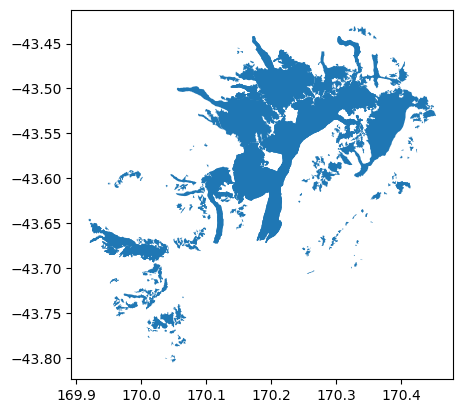

In [10]:
glacier_2009.plot()

In [11]:
# glims_wgms_2009.to_csv("glims_wgms_2009.csv", index=False)

## Glacier 2016

In [12]:
glacier_2016 = gpd.read_file("data_cleaned/glims_wgms_2016.gpkg")

glacier_2016 = glacier_2016[["THICKNESS_CHANGE", "VOLUME_CHANGE", "geometry"]]
glacier_2016.head()

,THICKNESS_CHANGE,VOLUME_CHANGE,geometry
0,-18926.0,None,"POLYGON Z ((170.04660 -43.73546 0.00000, 170.0..."
1,-16008.0,None,"POLYGON Z ((170.04660 -43.73546 0.00000, 170.0..."
2,-19631.0,None,"POLYGON Z ((170.04660 -43.73546 0.00000, 170.0..."
3,-21567.0,None,"POLYGON Z ((170.04660 -43.73546 0.00000, 170.0..."
4,-13431.0,None,"POLYGON Z ((170.04660 -43.73546 0.00000, 170.0..."


<Axes: >

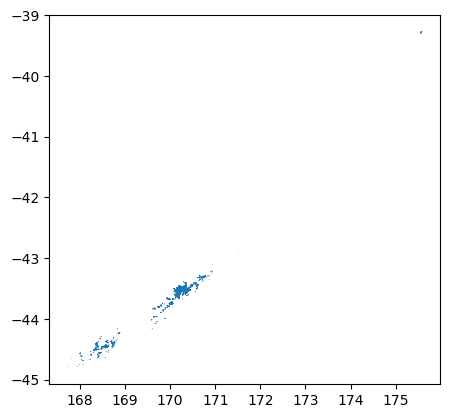

In [13]:
glacier_2016.plot()

## Glacier 2019

In [14]:
glacier_2019 = gpd.read_file("data_cleaned/glims_wgms_2019.gpkg")

glacier_2019 = glacier_2019[["THICKNESS_CHANGE", "VOLUME_CHANGE", "geometry"]]
glacier_2019.head()

,THICKNESS_CHANGE,VOLUME_CHANGE,geometry
0,-2530.0,-1710.0,"POLYGON Z ((170.39964 -43.60341 0.00000, 170.3..."
1,-8420.0,-5680.0,"POLYGON Z ((170.39964 -43.60341 0.00000, 170.3..."
2,-10260.0,-11000.0,"POLYGON Z ((170.42363 -43.52804 0.00000, 170.4..."
3,-4125.0,-4425.0,"POLYGON Z ((170.42363 -43.52804 0.00000, 170.4..."
4,-7720.0,-5660.0,"POLYGON Z ((168.58170 -44.36968 0.00000, 168.5..."


<Axes: >

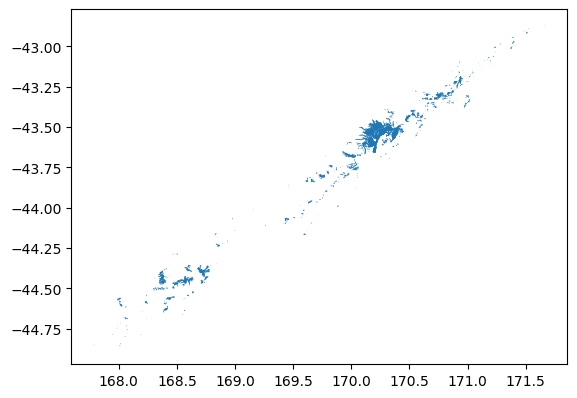

In [15]:
glacier_2019.plot()

# Plot

## 2009

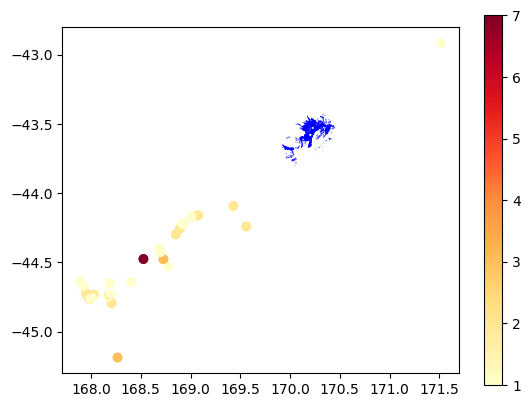

In [16]:
fig, ax = plt.subplots()
glacier_2009.plot(color='blue', ax=ax)
bird_2009.plot(column="OBSERVATION COUNT", ax=ax, legend=True, cmap= 'YlOrRd')
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.USGS.USTopo)
plt.show()

## 2016

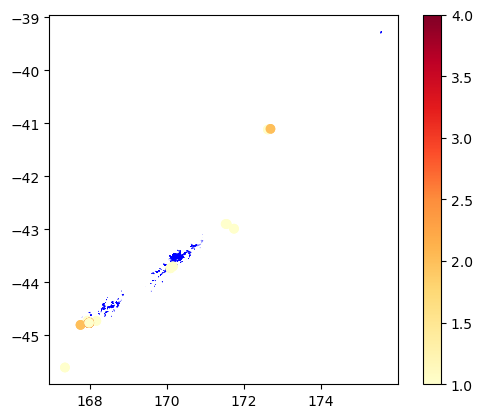

In [17]:
fig, ax = plt.subplots()
glacier_2016.plot(color='blue', ax=ax)
bird_2016.plot(column="OBSERVATION COUNT", ax=ax, legend=True, cmap= 'YlOrRd')
plt.show()

## 2019

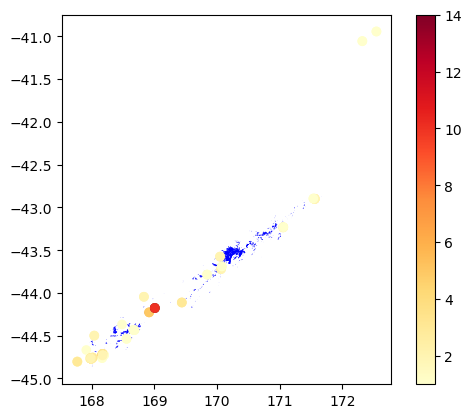

In [18]:
fig, ax = plt.subplots()
glacier_2019.plot(color='blue', ax=ax)
bird_2019.plot(column="OBSERVATION COUNT", ax=ax, legend=True, cmap= 'YlOrRd')
plt.show()

# Interpolation

## Prediction grid

In [19]:
bird_2009.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
xmin09, ymin09, xmax09, ymax09 = bird_2009.total_bounds
print(xmin09, ymin09, xmax09, ymax09)

167.8930011 -45.187 171.517226 -42.9142802


In [21]:
xmin16, ymin16, xmax16, ymax16 = bird_2016.total_bounds
print(xmin16, ymin16, xmax16, ymax16)

167.36082 -45.606113 172.6925093 -41.10425


In [22]:
xmin19, ymin19, xmax19, ymax19 = bird_2019.total_bounds
print(xmin19, ymin19, xmax19, ymax19)

167.771847 -44.8026801 172.54355 -40.942833


In [23]:
# The grid should cover all bird obs points
xmin = min(xmin09, xmin16, xmin19)
ymin = min(ymin09, ymin16, ymin19)
xmax = max(xmax09, xmax16, xmax19)
ymax = max(ymax09, ymax16, ymax19)

print(xmin, ymin, xmax, ymax)

167.36082 -45.606113 172.6925093 -40.942833


In [24]:
# x-coordinates of grid
gridx = np.arange(xmin - 0.05, xmax + 0.05, 0.1, dtype='float64')

# y-coordinates of grid
gridy = np.arange(ymin - 0.05, ymax + 0.05, 0.1, dtype='float64')

# Create a meshgrid
xi, yi = np.meshgrid(gridx, gridy)

In [25]:
len(yi)

48

## Bird 2019

In [26]:
# Train test split
train, test = train_test_split(bird_2019, test_size=0.35, random_state=777)

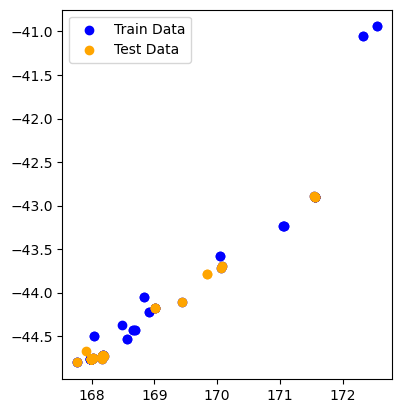

In [27]:
# Create a new figure and axis for the plot
fig, ax = plt.subplots()

# Plot the "train" data using blue color onto the specified axis
train.plot(color='blue', ax=ax,label='Train Data')

# Plot the "test" data using green color onto the same axis
test.plot(color='orange', ax=ax, label='Test Data')

# Add a legend to the plot
ax.legend()

# Display the plot
plt.show()

In [28]:
x = train.geometry.x
y = train.geometry.y
z = train['OBSERVATION COUNT']

### Method 1: Kriging

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.0847577970967
Full Sill: 1.2899184429617174
Range: 0.018346007790303237
Nugget: 1.2051606458650175 



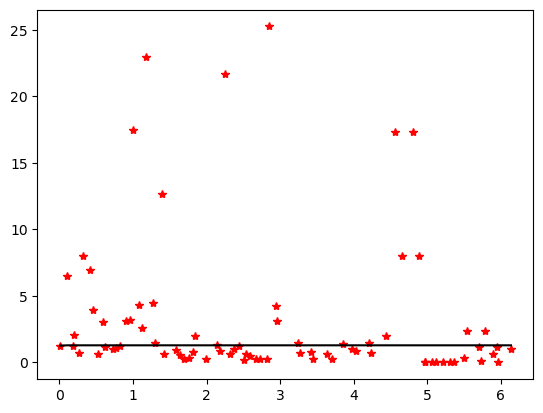

Calculating statistics on variogram model fit...
Q1 = 0.09201805186995418
Q2 = 2.607233187956065
cR = 3.53703767884537 



In [29]:
# Try different variogram models for class OrdinaryKriging()

# exponential
krig_interp_exp = OrdinaryKriging(
    x, y, z,
    variogram_model='exponential',
    verbose=True,
    enable_plotting=True,
    enable_statistics=True,
    nlags=100)

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 0.027932383168558613
Full Sill: 1.2899184785146351
Range: 0.10095948988723419
Nugget: 1.2619860953460766 



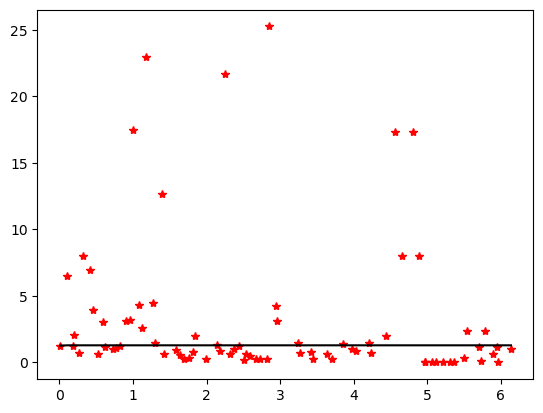

Calculating statistics on variogram model fit...
Q1 = 0.08480160554990666
Q2 = 2.724902769025206
cR = 3.6920496597677257 



In [30]:
# spherical

krig_interp_sph = OrdinaryKriging(
    x, y, z,
    variogram_model='spherical',
    verbose=True,
    enable_plotting=True,
    enable_statistics=True,
    nlags=100)

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 3.8096352410755213e-23
Nugget: 1.289214611953262 



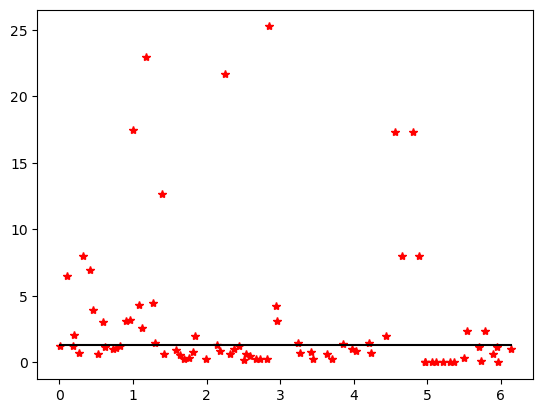

Calculating statistics on variogram model fit...
Q1 = 0.09482998624001582
Q2 = 2.8072242086826735
cR = 3.8083454108755688 



In [31]:
# linear

krig_interp_lin = OrdinaryKriging(
    x, y, z,
    variogram_model='linear',
    verbose=True,
    enable_plotting=True,
    enable_statistics=True,
    nlags=100)

**Q1 shoould be as to zero as possible, Q2 should be as close to 1 as possible, and cR should be as small as possible.**

In [32]:
krig_z, krig_var = krig_interp_exp.execute("grid", gridx, gridy)

Executing Ordinary Kriging...



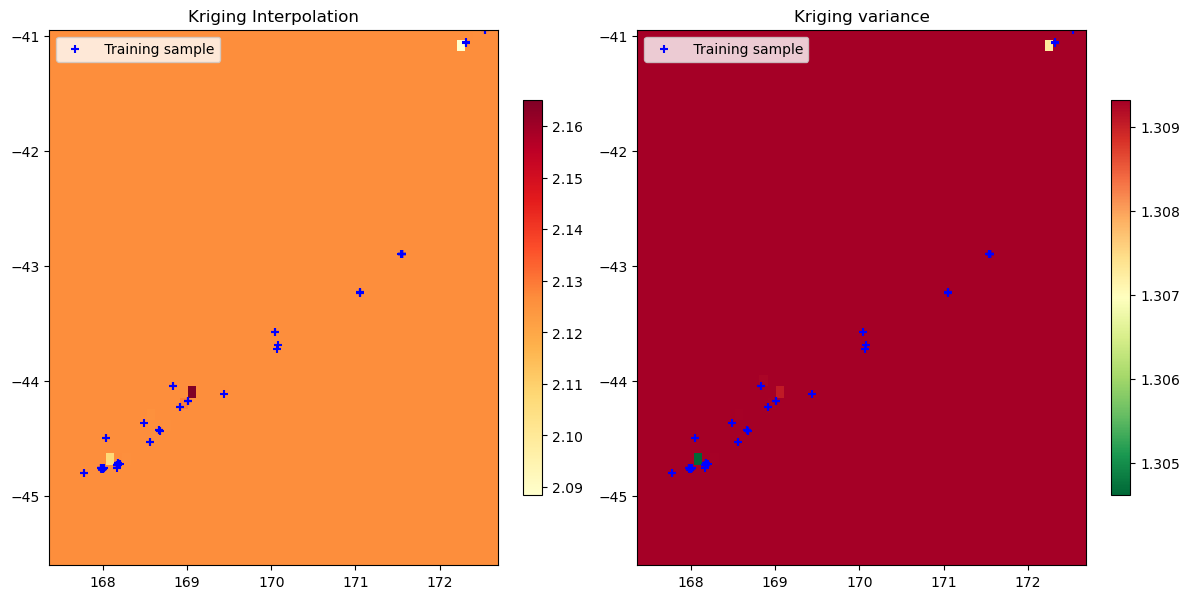

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

# Plot data on the first panel
cax = axes[0].imshow(krig_z, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='YlOrRd')
axes[0].set_title('Kriging Interpolation')
train.plot(color='blue', ax=axes[0], marker='+', label=" Training sample")
cbarx = plt.colorbar(cax, fraction=0.04)
axes[0].legend()

# Plot data on the second panel
cay = axes[1].imshow(krig_var, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap="RdYlGn_r")
axes[1].set_title('Kriging variance')
train.plot(color='blue', ax=axes[1], marker='+', label=" Training sample")
cbarx = plt.colorbar(cay, fraction=0.04)
axes[1].legend()

plt.tight_layout()

### Method 2: Nearest neighbour interpolation

In [34]:
nnb_interp = NearestNDInterpolator(list(zip(x, y)), z)

nnb_z = nnb_interp(xi, yi)

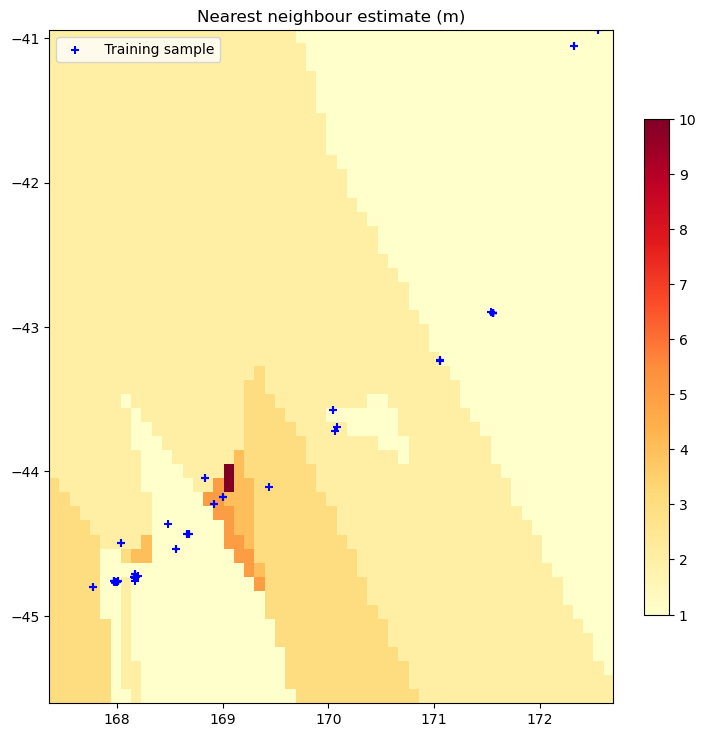

In [35]:
fig, ax = plt.subplots(figsize=(8, 10))

cax = ax.imshow(nnb_z, extent=(xmin, xmax, ymin, ymax), origin='lower',cmap='YlOrRd')

train.plot(color='blue', ax=ax, marker='+', label=" Training sample")

cbar = plt.colorbar(cax, fraction=0.04)

ax.legend()

plt.title('Nearest neighbour estimate (m)')

plt.show()

### Compare 2 Methods on test

In [36]:
aff = Affine(0.1, 0.0, xmin-0.05, 0.0, -0.1, ymin-0.05)
inv_aff= ~aff

In [37]:
test['col'], test['row'] = inv_aff * (test.geometry.x, test.geometry.y)
test

,OBSERVATION COUNT,geometry,col,row
3774,2.0,POINT (167.98690 -44.76420),6.760800,-8.919130
582,4.0,POINT (169.00808 -44.17597),16.972636,-14.801421
4648,1.0,POINT (168.17035 -44.72697),8.595300,-9.291390
4736,3.0,POINT (167.98690 -44.76420),6.760800,-8.919130
4712,2.0,POINT (167.98690 -44.76420),6.760800,-8.919130
4701,3.0,POINT (167.98690 -44.76420),6.760800,-8.919130
2768,1.0,POINT (169.84142 -43.78531),25.306010,-18.708010
4716,1.0,POINT (167.98690 -44.76420),6.760800,-8.919130
1536,4.0,POINT (168.16820 -44.73909),8.573758,-9.170277
1539,1.0,POINT (167.98690 -44.76420),6.760800,-8.919130


In [38]:
# flip upside down the result
def fp_arr_updn(arr):
    """
    Flip an array vertically (upside down).

    Parameters:
        arr (numpy.ndarray): Input array to be flipped.

    Returns:
        numpy.ndarray: Vertically flipped array.
    """

    # Get the total number of rows in the input array
    n_rows = arr.shape[0]
    
    # Create an index array with reversed row indices
    idx_reversed = np.arange(n_rows)[::-1]
    
    # Index the array using the reversed index values
    indexed_arr = arr[idx_reversed, :]
    
    return indexed_arr

In [39]:
# Add Nearest Neighbor (NN) estimate to the test dataset
test['NN_estimate'] = fp_arr_updn(nnb_z)[test.row.astype(int), test.col.astype(int)]

# Add Spherical Kriging estimate to the test dataset
test['kriging_estimate'] = fp_arr_updn(krig_z)[test.row.astype(int), test.col.astype(int)]

# Inspect the results
test

,OBSERVATION COUNT,geometry,col,row,NN_estimate,kriging_estimate
3774,2.0,POINT (167.98690 -44.76420),6.760800,-8.919130,1.0,2.126461
582,4.0,POINT (169.00808 -44.17597),16.972636,-14.801421,5.0,2.126461
4648,1.0,POINT (168.17035 -44.72697),8.595300,-9.291390,1.0,2.126461
4736,3.0,POINT (167.98690 -44.76420),6.760800,-8.919130,1.0,2.126461
4712,2.0,POINT (167.98690 -44.76420),6.760800,-8.919130,1.0,2.126461
4701,3.0,POINT (167.98690 -44.76420),6.760800,-8.919130,1.0,2.126461
2768,1.0,POINT (169.84142 -43.78531),25.306010,-18.708010,2.0,2.126461
4716,1.0,POINT (167.98690 -44.76420),6.760800,-8.919130,1.0,2.126461
1536,4.0,POINT (168.16820 -44.73909),8.573758,-9.170277,1.0,2.126461
1539,1.0,POINT (167.98690 -44.76420),6.760800,-8.919130,1.0,2.126461


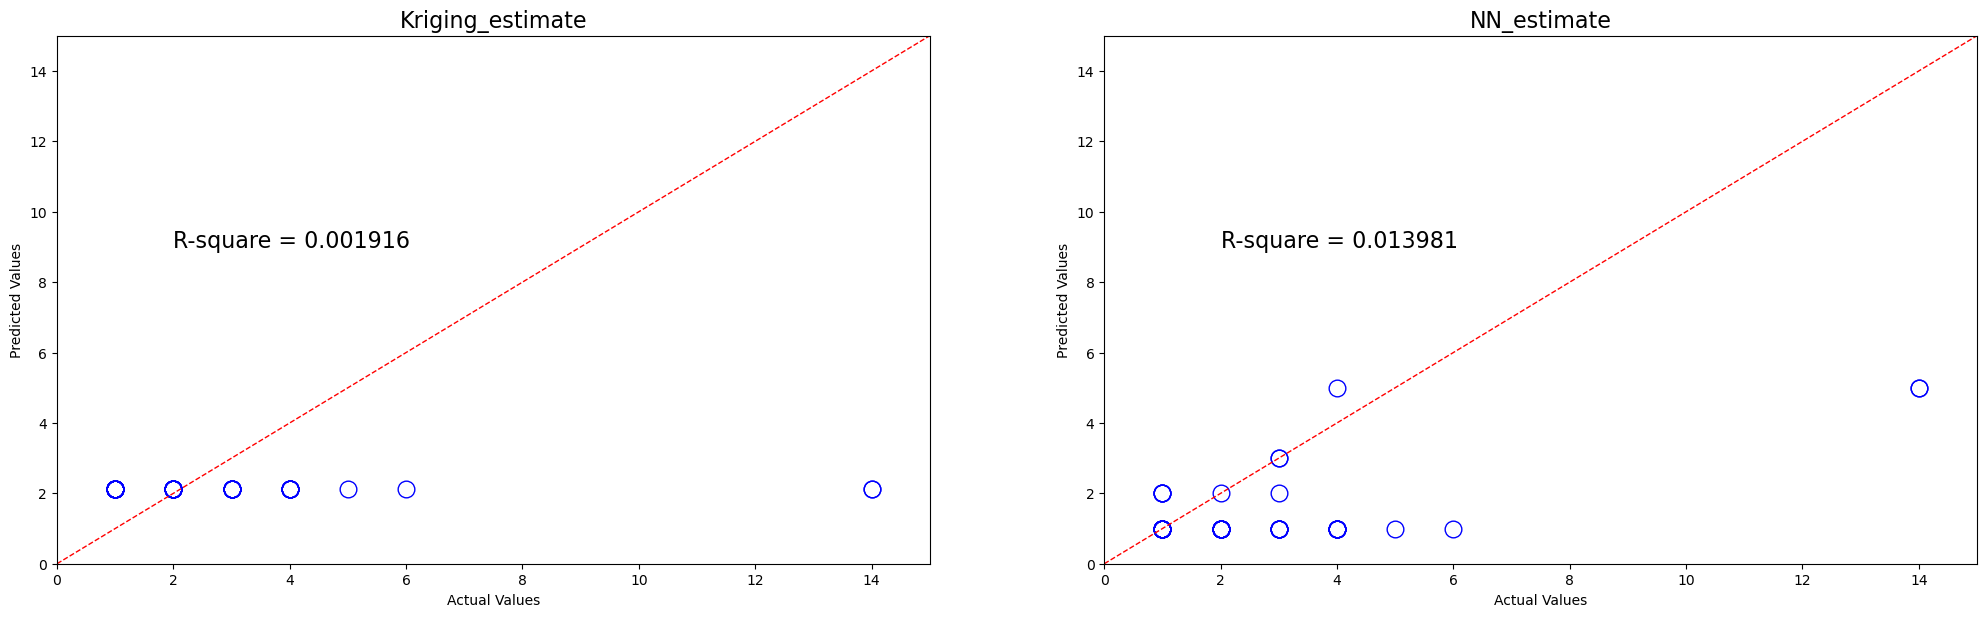

In [40]:
# Extract the actual values
actual_values = test['OBSERVATION COUNT']

## Define Kriging subplot
plt.subplot(121)  # Create a subplot with 1 row, 3 columns, and index 3 (third subplot)

# Plot actual vs. estimated values as blue circles with no fill
plt.plot(actual_values, test.kriging_estimate, 
         "o", color='b', markersize=12, fillstyle='none')

# Plot a dashed red line representing y=x (perfect prediction)
plt.plot([0, 15], [0, 15], color='r', linewidth=1, linestyle="--") 

# Calculate R-square and display it as text on the plot
r2_kriging = r2_score(actual_values, test.kriging_estimate) ** 2
plt.text(2, 9, f'R-square = {r2_kriging:.6f}', fontsize=16)

# Set the title for the subplot
plt.title('Kriging_estimate', fontsize=16)

# Set labels for the x and y axes
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Set limits for the x and y axes
plt.xlim([0, 15])
plt.ylim([0, 15])

##########################################################

## Define NN subplot
# Create a subplot with 1 row, 3 columns, and index 1 (first subplot)
plt.subplot(122)  # plt.subplot(nrows, ncols, index)

# Plot actual vs. estimated values as blue circles with no fill
plt.plot(actual_values, test['NN_estimate'], 
         "o", color='b', markersize=12, fillstyle='none')

# Plot a dashed red line representing y=x (perfect prediction)
plt.plot([0, 15], [0, 15], color='r', linewidth=1, linestyle="--") 

# Calculate R-square and display it as text on the plot
r2_nn = r2_score(actual_values, test.NN_estimate) ** 2
plt.text(2, 9, f'R-square = {r2_nn:.6f}', fontsize=16)

# Set the title for the subplot
plt.title('NN_estimate', fontsize=16)

# Set labels for the x and y axes
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Set limits for the x and y axes
plt.xlim([0, 15])
plt.ylim([0, 15])


# Adjust the layout of the subplots with specific spacing
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2)

# Display the plot
plt.show()

In [41]:
r2_kriging

0.0019156661673189264

In [42]:
r2_nn

0.013981215863348074

### Export NN Interpolate on 2019 bird data

In [43]:
xi_flat = xi.flatten()
yi_flat = yi.flatten()
nnb_z_flat = nnb_z.flatten()

In [44]:
nnb_output_2019 = pd.DataFrame({
    'X': xi_flat,
    'Y': yi_flat,
    'nnb_z': nnb_z_flat
})

In [45]:
nnb_output_2019.to_csv("interpolation/nnb_output_2019.csv", index=False)

## Bird 2009

In [46]:
x = bird_2009.geometry.x
y = bird_2009.geometry.y
z = bird_2009['OBSERVATION COUNT']

In [47]:
nnb_interp = NearestNDInterpolator(list(zip(x, y)), z)
nnb_z = nnb_interp(xi, yi)

In [48]:
xi_flat = xi.flatten()
yi_flat = yi.flatten()
nnb_z_flat = nnb_z.flatten()

In [49]:
nnb_output_2009 = pd.DataFrame({
    'X': xi_flat,
    'Y': yi_flat,
    'nnb_z': nnb_z_flat
})

In [50]:
nnb_output_2009_gpd = gpd.GeoDataFrame(
    nnb_output_2009, 
    geometry=gpd.points_from_xy(nnb_output_2009.X, nnb_output_2009.Y), 
    crs="EPSG:4326"
)

In [51]:
nnb_output_2009.to_csv("interpolation/nnb_output_2009.csv", index=False)

## Bird 2016

In [52]:
x = bird_2016.geometry.x
y = bird_2016.geometry.y
z = bird_2016['OBSERVATION COUNT']

In [53]:
nnb_interp = NearestNDInterpolator(list(zip(x, y)), z)
nnb_z = nnb_interp(xi, yi)

In [54]:
xi_flat = xi.flatten()
yi_flat = yi.flatten()
nnb_z_flat = nnb_z.flatten()

In [55]:
nnb_output_2016 = pd.DataFrame({
    'X': xi_flat,
    'Y': yi_flat,
    'nnb_z': nnb_z_flat
})

In [56]:
nnb_output_2016_gpd = gpd.GeoDataFrame(
    nnb_output_2016, 
    geometry=gpd.points_from_xy(nnb_output_2016.X, nnb_output_2016.Y), 
    crs="EPSG:4326"
)

In [57]:
nnb_output_2016.to_csv("interpolation/nnb_output_2016.csv", index=False)